<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/Open_filr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
# Clone the repository
!git clone https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python-2E.git

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import plotly.io as pio
pio.templates.default = "plotly_white"
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import missingno as msno
from itertools import cycle
from sklearn.metrics import mean_absolute_error
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed()
tqdm.pandas()

# Navigate to the repository's root directory
%cd Modern-Time-Series-Forecasting-with-Python-2E

from src.utils.data_utils import compact_to_expanded
from src.imputation.interpolation import SeasonalInterpolation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd

In [ ]:
os.makedirs("/content/drive/MyDrive/Books/Modern Time Series Forecasting/Chapter II/imgs/chapter_2", exist_ok=True)
preprocessed = Path("/content/drive/MyDrive/Books/Modern Time Series Forecasting/Data/data/london_smart_meters/data/london_smart_meters/preprocessed")
base_directory = Path("/content/drive/MyDrive/Books/Modern Time Series Forecasting/Chapter II/")

In [ ]:
def format_plot(fig, legends = None, font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": title_font_size
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text="Value",
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text="Day",
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

In [ ]:
from itertools import cycle
from src.utils import plotting_utils

def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", figsize=(500,900), font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=figsize[1],
            height=figsize[0],
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

### Reading Market Volumes data:

In [ ]:
try:
    block_df = pd.read_csv(base_directory/"vol.csv", skiprows=3)
    display(block_df.head())
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 02 - Preprocessing London Smart Meter Dataset.ipynb in Chapter02
    </div>
    """))

In [ ]:
block_df["Dates"] = pd.to_datetime(block_df["Dates"],format="%d/%m/%Y")
block_df.set_index("Dates", inplace=True)
block_df.head()

In [ ]:
msno.matrix(block_df, fontsize=10)
#plt.savefig('/content/drive/MyDrive/Books/Modern Time Series Forecasting/Chapter II/imgs/chapter_2/imgs/missing_no_full.png', bbox_inches='tight')
plt.show()

In [ ]:
filtered_block_df = block_df[(block_df.index >= pd.to_datetime("2024-06-03", format="%Y-%m-%d")) & (block_df.index <= pd.to_datetime("2025-04-03", format="%Y-%m-%d"))]
msno.matrix(filtered_block_df, fontsize=10)
#plt.savefig('imgs/chapter_2/missing_no_mac000193.png', bbox_inches='tight')
plt.show()

Whereas all the obs are missing that date is removed:

In [ ]:
block_df = block_df.dropna(axis=0, thresh=0.9)
msno.matrix(block_df, fontsize=10)
plt.show()

In [ ]:
sec = "6472 JT Equity"
ts_df = block_df[[sec]]


ts_df["day"] = ts_df.index.day
ts_df["weekday"] = ts_df.index.weekday
ts_df["month"] = ts_df.index.month
ts_df["year"] = ts_df.index.year

In [ ]:
fig = px.line(ts_df, y=sec, title=f"{sec} Volumes")
fig = format_plot(fig)
#fig.write_image("imgs/chapter_2/mac000193_missing.png")
fig.show()

In [ ]:
week_profile = ts_df.groupby(['weekday'])[sec].mean().reset_index()

In [ ]:
fig = px.line(week_profile, y=sec, title=f"{sec} Volumes")
fig = format_plot(fig)
#fig.write_image("imgs/chapter_2/mac000193_missing.png")
fig.show()

In [ ]:
month_profile = ts_df.groupby(['month'])[sec].mean().reset_index()

In [ ]:
fig = px.line(month_profile, y=sec, title=f"{sec} Volumes")
fig = format_plot(fig)
#fig.write_image("imgs/chapter_2/mac000193_missing.png")
fig.show()

In [ ]:
month_day_profile = ts_df.groupby(['month',"day"])[sec].mean().reset_index()

In [ ]:
month_day_profile

# Hourly Profiles by week Day
px.line(month_day_profile, x="day", y=sec, color="month", title="Daily Profiles by Month: Jan (0-Monday - 4-Friday)")

In [ ]:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", figsize=(500,900), font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=figsize[1],
            height=figsize[0],
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

In [ ]:
#Montlhly Average energy consumption
plot_df = ts_df.groupby(["year", "month"],observed=False)[[sec]].mean().reset_index()

In [ ]:
fig = px.line(plot_df, x="month", y=sec, color="year", line_dash="year", title="Seasonal Plot - Monthly")
fig = format_plot(fig, ylabel=sec, xlabel="Month")
fig.update_layout(legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ))
#fig.write_image("imgs/chapter_3/seasonal_plot_monthly.png")
fig.show()

## Seasonal Box Plots

In [ ]:
plot_df =  ts_df.groupby(["month","day"],observed=False)[sec].mean().reset_index().dropna()

In [ ]:
fig = px.box(plot_df, y=sec, x="month", log_y=True, title="Box Plot: Month Average")
fig = format_plot(fig, ylabel="Volumes", xlabel="Month", legends=None)
#fig.write_image("imgs/chapter_3/box_plot_hourly_avg.png")
fig.show()

## Calendar Heatmap

In [ ]:
plot_df = pd.pivot_table(ts_df, index="month", values=sec, columns="day", aggfunc="mean")
# plot_df.index = "Day "+ plot_df.index.astype(str)
plot_df

In [ ]:
fig = px.imshow(plot_df, height=600, width=1200, title="Energy Consumption: Hours vs Week Day")
fig = format_plot(fig, ylabel="Day", xlabel="Month", legends=None)
#fig.write_image("imgs/chapter_3/hour_weekday_heatmap.png")
fig.show()

# Autocorrelation Plots

In [ ]:
from src.decomposition.seasonal import MultiSeasonalDecomposition, STL
stl = MultiSeasonalDecomposition(seasonal_model="fourier",seasonality_periods=["day_of_year","month"], model = "additive", n_fourier_terms=10, )
res = stl.fit(ts_df[sec])

In [ ]:
fig = plotting_utils.plot_autocorrelation(res.resid, vertical=True)
#fig.write_image("imgs/chapter_3/acf_pacf.png")
fig.show()

In [ ]:
fig = px.line(month_day_profile, y=sec, title=f"{sec} Volumes")
fig = format_plot(fig)
#fig.write_image("imgs/chapter_2/mac000193_missing.png")
fig.show()

In [ ]:
ts_df.tail(63)

# 3.0 **Decomposing Time Series**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import os
import plotly.io as pio
pio.templates.default = "plotly_white"
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from IPython.display import display, HTML
import missingno as msno
import statsmodels.api as sm
from statsmodels.tsa.seasonal import MSTL , DecomposeResult

import requests
from io import StringIO
# %load_ext autoreload
# %autoreload 2
np.random.seed()
tqdm.pandas()

In [ ]:
from itertools import cycle


def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

## Seasonal Decomposition

In [ ]:
ts_df.head()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from src.decomposition.seasonal import STL, FourierDecomposition, MultiSeasonalDecomposition

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
def decomposition_plot(
        ts_index, observed=None, seasonal=None, trend=None, resid=None
    ):
        """Plots the decomposition output
        """
        series = []
        if observed is not None:
            series += ["Original"]
        if trend is not None:
            series += ["Trend"]
        if seasonal is not None:
            series += ["Seasonal"]
        if resid is not None:
            series += ["Residual"]
        if len(series) == 0:
            raise ValueError(
                "All component flags were off. Need atleast one of the flags turned on to plot."
            )
        fig = make_subplots(
            rows=len(series), cols=1, shared_xaxes=True, subplot_titles=series
        )
        x = ts_index
        row = 1
        if observed is not None:
            fig.append_trace(
                go.Scatter(x=x, y=observed, name="Original"), row=row, col=1
            )
            row += 1
        if trend is not None:
            fig.append_trace(
                go.Scatter(x=x, y=trend, name="Trend"), row=row, col=1
            )
            row += 1
        if seasonal is not None:
            fig.append_trace(
                go.Scatter(x=x, y=seasonal, name="Seasonal"),
                row=row,
                col=1,
            )
            row += 1
        if resid is not None:
            fig.append_trace(
                go.Scatter(x=x, y=resid, name="Residual"), row=row, col=1
            )
            row += 1

        fig.update_layout(
            title_text="Seasonal Decomposition",
            autosize=False,
            width=1200,
            height=700,
            title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
            titlefont={"size": 20},
            legend_title=None,
            showlegend=False,
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
        return fig

## Moving Averages

**seasonal_decompose from statsmodel**

statsmodels.tsa.seasonal has a function called seasonal_decompose. This is an
implementation that uses moving averages for the trend component and period-adjusted averages
for the seasonal component. It supports both additive and multiplicative modes of decomposition.
However, it doesn’t tolerate missing values. Let’s see how we can use it

In [ ]:
ts = ts_df[sec].values.squeeze()
ts
365/2

In [ ]:
#Does not support misssing values, so using imputed ts instead
res = seasonal_decompose(ts, period=365, model="additive", extrapolate_trend="freq", filt=np.repeat(1/180, 180))

A few key parameters to keep in mind are as follows:
* period is the seasonal period you expect the pattern to repeat.
* model takes additive or multiplicative as arguments to determine the type
of decomposition.
* filt takes in an array that is used as the weights in the moving average (convolution, to be
specific). It can also be used to define the window over which we need our moving average.
We can increase it to smooth out the trend component to some extent.
* extrapolate_trend is a parameter that we can use to extend the trend component to both
sides to avoid the missing values that are generated when applying the moving average filter.
* two_sided is a parameter that lets us define how the moving averages are calculated. If True,
which it is by default, the moving average is calculated using the past as well as future values
because the window for the moving average is centered. If False, it only uses past values to
calculate the moving average.

Let’s see how well we have been able to decompose one of the time series in our datasets. We used
period=7*48 to capture a weekday-hourly profile and filt=np.repeat(1/(30*48),
30*48) to make the moving average over 30 days with uniform weights:

In [ ]:
fig = decomposition_plot(ts_df.index, res.observed, res.seasonal, res.trend, res.resid)
#fig.write_image("imgs/chapter_3/moving_avg_decomposition.png")
fig.show()

## Seasonality and Trend Decomposition using LOESS (STL)

As we saw earlier, LOESS is much more suited for trend estimation. Seasonality and trend decomposition using LOESS (STL) is an implementation that uses LOESS for trend estimation and period averages for seasonality. Although statsmodels has an implementation, we have reimplemented it for better performance and flexibility. This implementation can be found in this book’s GitHub repository under src.decomposition.seasonal.py. It expects a pandas DataFrame or series with a datetime index as an input. Let’s see how we can use this:

In [ ]:
#Supports missing values and expects a series or dataframe with datetime index
stl = STL(seasonality_period=365, model = "multiplicative")
res_new = stl.fit(ts_df[sec])

The key parameters here are as follows:
* **seasonality_period** is the seasonal period you expect the pattern to repeat.
* **model** takes additive or multiplicative as arguments to determine the type
of decomposition.
* **lo_frac** is the fraction of the data that will be used to fit the LOESS regression.
* **lo_delta** is the fractional distance within which we use a linear interpolation instead of
weighted regression. Using a non-zero lo_delta significantly decreases computation time.

Let’s see what this decomposition looks like. Here, we used seasonality_period=7*48 to
capture a weekday-hourly profile:

In [ ]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
#fig.write_image("imgs/chapter_3/stl_decomposition.png")
fig.show()

The trend is smooth enough now and seasonality has also been captured. Here, we can clearly see the
hourly peaks and valleys and the higher peaks on weekends. But since we are relying on averages to
derive the seasonality, it is also highly influenced by outliers. A few very high or very low values in the time series will skew your seasonality profile that’s been derived from period averages. Another disadvantage of this technique is that the “goodness” of the seasonality that’s been extracted suffers when the difference between the resolution of the data and the expected seasonality cycle is greater. For instance, when extracting a yearly seasonality on daily or sub-daily data, this would make the extracted seasonality very noisy. This technique will also not work if you have less than two cycles of the expected seasonality – for instance, if we want to extract a yearly seasonality, but we have less than 2 years of data.

## Seasonality and Trend Decomposition using Loess and Fourier Terms (Fourier Decomposition)

We can find the Python implementation for decomposing a time series using Fourier terms in src.
decomposition.seasonal.py. It uses LOESS for trend detection and Fourier terms for seasonality
extraction. There are two ways we can use it. First, we can specify seasonality_period as one
of the pandas datetime properties (such as hour, week_of_day, and so on):

In [ ]:
#Doesn't support missing values, and expects a series or datafeame with datetime index
stl = FourierDecomposition(seasonality_period="day", model = "additive", n_fourier_terms=5)
res_new = stl.fit(pd.Series(ts.squeeze(), index=ts_df.index))

In [ ]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
#fig.write_image("imgs/chapter_3/fourier_decomposition_hourly.png")
fig.show()

 - **Custom Seasonality**

Alternatively, we can create any custom seasonality array that’s the same length as the time series that has an ordinal representation of the seasonality. If it is an annual seasonality of daily data, the array would have a minimum value of 1 and a maximum value of 365 as it increases by one every day of the year:

In [ ]:
#Making a custom seasonality term
ts_df["dayofweek"] = ts_df.index.dayofweek
ts_df["month"] = ts_df.index.month
#Creating a sorted unique combination df
map_df = ts_df[["dayofweek","month"]].drop_duplicates().sort_values(["dayofweek", "month"])
# Assigning an ordinal variable to capture the order
map_df["map"] = np.arange(1, len(map_df)+1)
# mapping the oprdinal mapping back to the original df and getting the seasonality array
seasonality = ts_df.merge(map_df, on=["dayofweek","month"], how='left', validate="many_to_one")['map']

In [ ]:
map_df
seasonality

In [ ]:
stl = FourierDecomposition(model = "additive", n_fourier_terms=50)
res_new = stl.fit(pd.Series(ts, index=ts_df.index), seasonality=seasonality)

In [ ]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
#fig.write_image("imgs/chapter_3/fourier_decomposition.png")
fig.show()

The trend is going to be the same as the STL one because we are using LOESS here as well. The
seasonality profile may be slightly different and robust to outliers because we are doing regularized regression using the Fourier terms on the signal. Another advantage is that we have decoupled the resolution of the data and the expected seasonality. Now, extracting a yearly seasonality on sub-daily data is not as challenging as with period averages.
So far, we have only seen techniques that extract one seasonality per series; mostly, we extract the major seasonality. So, what do we do when we have multiple seasonal patterns?

## Multiple seasonality decomposition using LOESS (MSTL)
Time series with high-frequency data (such as daily, hourly, or minutely data) are prone to exhibit
multiple seasonal patterns. For instance, there may be an hourly seasonality pattern, a weekly seasonality pattern, and a yearly seasonality pattern. But if we extract only the dominant pattern and leave the rest to residuals, we are not doing justice to the decomposition. Kasun Bandara et al. proposed an extension of STL decomposition for ***multiple seasonality, known as multiple seasonal-trend decomposition using LOESS (MSTL)***, and a corresponding implementation is present in the R ecosystem. A very similar implementation in Python can be found in src.decomposition.seasonal.py. In addition to MSTL, the implementation extracts multiple seasonality using Fourier terms.

In [ ]:
48*365, 48*7, 48

In [ ]:
stl = MultiSeasonalDecomposition(seasonal_model="averages",seasonality_periods=[365, 31], model = "additive")
res_new = stl.fit(pd.Series(ts, index=ts_df.index))

In [ ]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
#fig.write_image("imgs/chapter_3/mstl_decomposition_averages.png")
fig.show()

Here, we can see that the day_of_week seasonality has been extracted. To see the day_of_week
and hour seasonal components, we need to zoom in a bit

In [ ]:
fig.update_xaxes(type="date", range=["2020-01-01", "2021-01-01"])
#fig.write_image("imgs/chapter_3/mstl_decomposition_averages_zoomed.png")
fig.show()

## Using Fourier Decomposition as seasonal model

The key parameters here are as follows:
* **seasonality_periods** is the list of expected seasonalities. For STL, it is a list of seasonal
periods, while for FourierDecomposition, it is a list of strings that denotes pandas
datetime properties.
* **seasonality_model** takes fourier or averages as arguments to determine the type
of seasonality decomposition.
* **model** takes additive or multiplicative as arguments to determine the type
of decomposition.
* **n_fourier_terms** determines the number of Fourier terms to be used to extract the
seasonality. As we increase this parameter, the more complex the seasonality that is extracted
from the data.
70 Analyzing and Visualizing Time Series Data
* **lo_frac** is the fraction of the data that will be used to fit the LOESS regression.
* **lo_delta** is the fractional distance within which we use linear interpolation instead of
weighted regression. Using a non-zero lo_delta significantly decreases computation time.

Let’s see what the decomposition looks like when using Fourier decomposition

In [ ]:
stl = MultiSeasonalDecomposition(seasonal_model="fourier",seasonality_periods=["day_of_year", "quarter", "month",], model = "additive", n_fourier_terms=10)
res_new = stl.fit(pd.Series(ts, index=ts_df.index))

In [ ]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
#fig.write_image("imgs/chapter_3/mstl_decomposition_fourier.png")
fig.show()

In [ ]:
fig.update_xaxes(type="date", range=["2022-11-4", "2023-12-4"])
#fig.write_image("imgs/chapter_3/mstl_decomposition_fourier_zoomed.png")
fig.show()

Here, we can observe that the hour seasonality has been extracted well and that it has also isolated the day_of_week seasonal component, which peaks on weekends. The discrete step nature of the day_of_week seasonal component is because the frequency of the data is half-hourly, and for 48
data points, day_of_week will be the same.
We have summarized the four techniques we’ve covered in the following table:


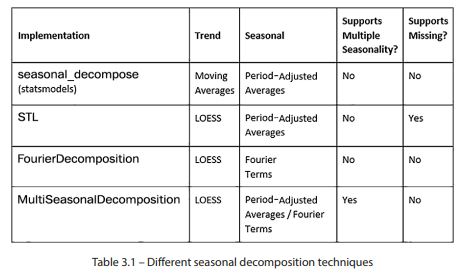

## Multiple seasonality decomposition using LOESS

Time series with high-frequency data (such as daily, hourly, or minutely data) are prone to exhibit
multiple seasonal patterns. For instance, there may be an hourly seasonality pattern, a weekly seasonality pattern, and a yearly seasonality pattern. But if we extract only the dominant pattern and leave the rest to residuals, we are not doing justice to the decomposition. Kasun Bandara et al. proposed an extension of STL decomposition for multiple seasonality, known as **multiple seasonal-trend decomposition using LOESS (MSTL)**, and a corresponding implementation is present in the R ecosystem. A very similar implementation in Python can be found in src.decomposition.seasonal.py. In addition to MSTL, the implementation extracts multiple seasonality using Fourier terms.

### MSTL decomposition in STATSMODELS
We will break out time series up in to daily and weekly seasonal components.

In [ ]:
exp_block_df = ts_df[[sec]]
exp_block_df.head()

In [ ]:
ts_df_mstl = exp_block_df.copy() #exp_block_df[exp_block_df.LCLid=="MAC000050"][['timestamp','energy_consumption']].set_index('timestamp')
ts_df_mstl.head()
ts_df_mstl['6472 JT Equity']

In [ ]:
stl_kwargs = {"seasonal_deg": 0, }
mstl = MSTL(ts_df_mstl[sec],
            periods=[30, 365],
            #windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
            #stl_kwargs = stl_kwargs,
            )
res = mstl.fit()

In [ ]:
res.trend.head()

In [ ]:
res.seasonal.head()

In [ ]:
res.resid.head()

In [ ]:
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

# Creating a plot
fig = res.plot()

#for ax in fig.axes:
#    ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-02-01'))

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()